In [38]:
from numba import cuda, float32
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1
import numpy as np
import matplotlib.cbook as cbook
import matplotlib.image as image
import matplotlib.pyplot as plt
import cv2
import time

(1440, 2560, 3)


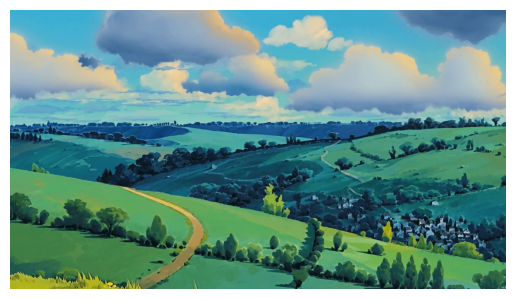

In [39]:
# load image from file(matplotlib's imread)
with cbook.get_sample_data('/content/sample.jpg') as image_file:
  img = plt.imread(image_file)

print(img.shape)
fig, ax = plt.subplots()
ax.imshow(img)
ax.axis('off')

plt.show()

In [40]:
h, w, c = img.shape
print("Image shape:", img.shape)

Image shape: (1440, 2560, 3)


Grayscale time: 0.086694 seconds


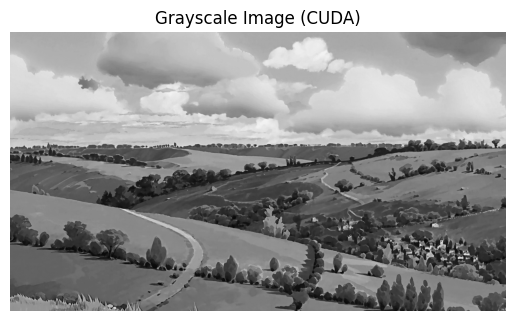

In [49]:
@cuda.jit
def grayscale(src, dst):
    x, y = cuda.grid(2)
    if x < src.shape[0] and y < src.shape[1]:
        g = (src[x, y, 0] + src[x, y, 1] + src[x, y, 2]) / 3
        dst[x, y] = np.uint8(g)

# GPU memory allocation
d_img = cuda.to_device(img)
d_gray = cuda.device_array((h, w), dtype=np.uint8)

threadsperblock = (16, 16)
blockspergrid_x = (h + threadsperblock[0] - 1) // threadsperblock[0]
blockspergrid_y = (w + threadsperblock[1] - 1) // threadsperblock[1]
blockspergrid = (blockspergrid_x, blockspergrid_y)

start = time.time()
grayscale[blockspergrid, threadsperblock](d_img, d_gray)
cuda.synchronize()
end = time.time()
print(f"Grayscale time: {end - start:.6f} seconds")

gray_host = d_gray.copy_to_host()
plt.imshow(gray_host, cmap='gray')
plt.title("Grayscale Image (CUDA)")
plt.axis('off')
plt.show()

In [50]:
gauss7x7 = np.array([
    [0, 0, 1, 2, 1, 0, 0],
    [0, 3, 13, 22, 13, 3, 0],
    [1, 13, 59, 97, 59, 13, 1],
    [2, 22, 97, 159, 97, 22, 2],
    [1, 13, 59, 97, 59, 13, 1],
    [0, 3, 13, 22, 13, 3, 0],
    [0, 0, 1, 2, 1, 0, 0]
], dtype=np.float32)
gauss7x7 /= np.sum(gauss7x7)
d_kernel = cuda.to_device(gauss7x7)

In [51]:
@cuda.jit
def gaussian_blur_no_shared(src, dst, kernel):
    x, y = cuda.grid(2)
    ksize = 7
    khalf = ksize // 2
    if x < src.shape[0] and y < src.shape[1]:
        acc = 0.0
        for i in range(-khalf, khalf + 1):
            for j in range(-khalf, khalf + 1):
                xi = x + i
                yj = y + j
                if (0 <= xi < src.shape[0]) and (0 <= yj < src.shape[1]):
                    acc += src[xi, yj] * kernel[i + khalf, j + khalf]
        dst[x, y] = acc

In [63]:
from numba import cuda, float32

@cuda.jit
def gaussian_blur_shared(src, dst, kernel):
    ksize = 7
    khalf = ksize // 2
    tile = cuda.shared.array((22, 22), dtype=float32)

    x, y = cuda.grid(2)
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x * 16
    by = cuda.blockIdx.y * 16

    # Load tile
    for i in range(tx, 22, 16):
        for j in range(ty, 22, 16):
            xi = bx + i - khalf
            yj = by + j - khalf
            if 0 <= xi < src.shape[0] and 0 <= yj < src.shape[1]:
                tile[i, j] = src[xi, yj]
            else:
                tile[i, j] = 0
    cuda.syncthreads()

    # --- Convolution ---
    if x < src.shape[0] and y < src.shape[1]:
        acc = 0.0
        for i in range(ksize):
            for j in range(ksize):
                acc += tile[tx + i, ty + j] * kernel[i, j]
        dst[x, y] = acc


In [64]:
d_blur_no = cuda.device_array_like(d_gray)
d_blur_shared = cuda.device_array_like(d_gray)

start = time.time()
gaussian_blur_no_shared[blockspergrid, threadsperblock](d_gray, d_blur_no, d_kernel)
cuda.synchronize()
no_shared_time = time.time() - start
print(f"Gaussian Blur (no shared) time: {no_shared_time:.6f} seconds")

start = time.time()
gaussian_blur_shared[blockspergrid, threadsperblock](d_gray, d_blur_shared, d_kernel)
cuda.synchronize()
shared_time = time.time() - start
print(f"Gaussian Blur (with shared) time: {shared_time:.6f} seconds")

Gaussian Blur (no shared) time: 0.009304 seconds
Gaussian Blur (with shared) time: 0.231241 seconds


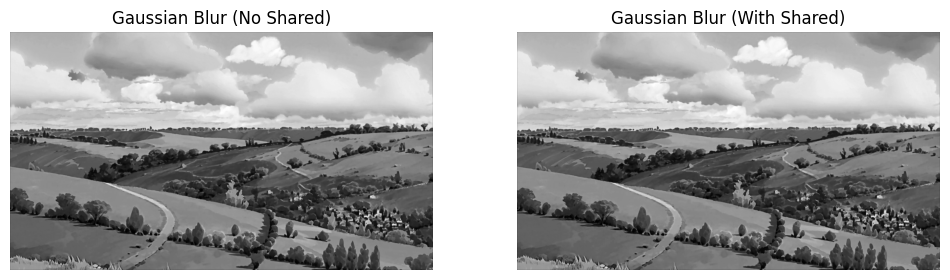

In [65]:
blur_no = d_blur_no.copy_to_host()
blur_shared = d_blur_shared.copy_to_host()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(blur_no, cmap='gray')
axs[0].set_title("Gaussian Blur (No Shared)")
axs[0].axis('off')

axs[1].imshow(blur_shared, cmap='gray')
axs[1].set_title("Gaussian Blur (With Shared)")
axs[1].axis('off')

plt.show()

In [67]:
def gaussian_kernel(ksize=7, sigma=1.0):
    khalf = ksize // 2
    ax = np.linspace(-khalf, khalf, ksize)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel = kernel / np.sum(kernel)
    return kernel.astype(np.float32)

kernel = gaussian_kernel(7, sigma=1.5)

Block 8x8: no_shared=0.0093s, shared=0.0091s
Block 16x16: no_shared=0.0091s, shared=0.0091s


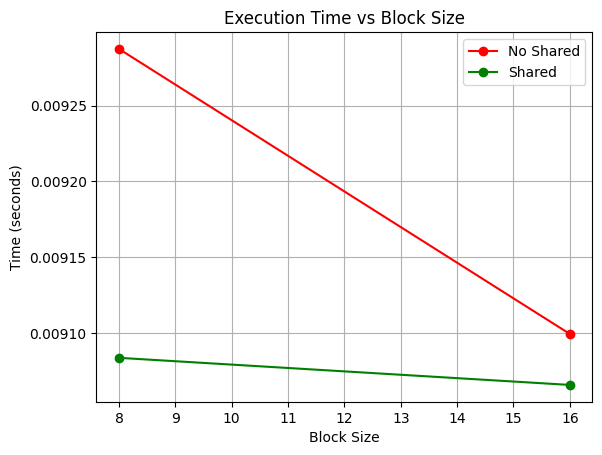

In [76]:
import math
times_no_shared = []
times_shared = []

block_sizes = [8, 16]

for bs in block_sizes:
    threadsperblock = (bs, bs)
    blockspergrid_x = math.ceil(img.shape[0] / bs)
    blockspergrid_y = math.ceil(img.shape[1] / bs)
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    # No-shared version
    start = time.time()
    gaussian_blur_no_shared[blockspergrid, threadsperblock](d_gray, d_blur_no, d_kernel)
    cuda.synchronize()
    t_no_shared = time.time() - start

    # Shared version
    start = time.time()
    gaussian_blur_shared[blockspergrid, threadsperblock](d_gray, d_blur_shared, d_kernel)
    cuda.synchronize()
    t_shared = time.time() - start

    times_no_shared.append(t_no_shared)
    times_shared.append(t_shared)
    print(f"Block {bs}x{bs}: no_shared={t_no_shared:.4f}s, shared={t_shared:.4f}s")

# compute speedup
speedups = np.array(times_no_shared) / np.array(times_shared)

plt.plot(block_sizes, times_no_shared, marker='o', color='red', label='No Shared')
plt.plot(block_sizes, times_shared, marker='o', color='green', label='Shared')
plt.title('Execution Time vs Block Size')
plt.xlabel('Block Size')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()